In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [5]:
import os
data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD']

In [9]:
for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'H1_'+i+'_2015.csv')
    print(data_path)
    df = pd.read_csv(data_path, index_col=0)
    if 'volume' not in df.columns:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

#     data = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date")
    break

/home/iftekhar/Make_Money_with_Tensorflow_2.0/forexPredictor/ohlc_data/EURUSD/H1_EURUSD_2015.csv


In [14]:
data["Close"] = data["Close"].rolling(window=9).mean()

In [15]:
df.columns

Index(['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'spread',
       'real_volume'],
      dtype='object')

In [16]:
df

,time,Open,High,Low,Close,Volume,spread,real_volume
0,1420048800,1.20997,1.21089,1.20966,1.20999,3237,17,0
1,1420185600,1.20481,1.20569,1.20479,1.20538,1254,17,0
2,1420189200,1.20537,1.20574,1.20341,1.20553,3394,17,0
3,1420192800,1.20556,1.20689,1.20442,1.20469,4590,17,0
4,1420196400,1.20468,1.20599,1.20380,1.20573,4335,17,0
...,...,...,...,...,...,...,...,...
61933,1734688800,1.03816,1.03974,1.03770,1.03913,5104,17,0
61934,1734692400,1.03913,1.03915,1.03749,1.03817,4389,17,0
61935,1734696000,1.03818,1.03921,1.03803,1.03908,3521,17,0
61936,1734699600,1.03908,1.03964,1.03785,1.03906,3663,17,0


In [17]:
data = df.sort_index()

In [34]:
# Ensure the dataset has a 'Close' column
if "Close" not in data.columns:
    raise ValueError("Dataset must have a 'Close' column.")

# Optimize moving averages
def optimize_moving_averages(data, short_range, long_range):
    """
    Optimize moving averages for crossover strategy with Buy/Sell/Hold signals.
    :param data: DataFrame containing 'Close' prices.
    :param short_range: Range of short-term moving averages to test.
    :param long_range: Range of long-term moving averages to test.
    :return: Best short and long window sizes, and their corresponding metrics.
    """
    results = []

    for short, long in product(short_range, long_range):
        if short >= long:  # Skip invalid combinations
            continue
        
        # Calculate moving averages
        data["Short_MA"] = data["Close"].rolling(window=short).mean()
        data["Long_MA"] = data["Close"].rolling(window=long).mean()

        # Generate signals: 1 = Buy, -1 = Sell, 0 = Hold
        data["Signal"] = 0
        data.loc[data["Short_MA"] > data["Long_MA"], "Signal"] = 1  # Buy
        data.loc[data["Short_MA"] < data["Long_MA"], "Signal"] = -1  # Sell
        data["Signal"] = data["Signal"].replace(to_replace=0, method="ffill").fillna(0)  # Hold

        # Calculate strategy returns
        data["Daily_Return"] = data["Close"].pct_change()
        data["Strategy_Return"] = data["Signal"].shift(1) * data["Daily_Return"]

        # Compute performance metrics
        total_return = data["Strategy_Return"].sum()
        sharpe_ratio = data["Strategy_Return"].mean() / data["Strategy_Return"].std() if data["Strategy_Return"].std() != 0 else 0

        results.append((short, long, total_return, sharpe_ratio))
    
    # Find the best combination based on Sharpe ratio
    best_combination = max(results, key=lambda x: x[3])  # Optimize for Sharpe ratio
    return best_combination, results

# Define ranges for short and long windows
short_range = range(5, 200, 5)  # Short-term MA window sizes (e.g., 5 to 20 days)
long_range = range(20, 1200,20)  # Long-term MA window sizes (e.g., 20 to 50 days)

# Run optimization
best_combination, all_results = optimize_moving_averages(data, short_range, long_range)

# Display best combination
print("Best Combination:")
print(f"Short MA: {best_combination[0]}, Long MA: {best_combination[1]}")
print(f"Total Return: {best_combination[2]:.2f}, Sharpe Ratio: {best_combination[3]:.2f}")

# Visualize the results
data["Short_MA"] = data["Close"].rolling(window=best_combination[0]).mean()
data["Long_MA"] = data["Close"].rolling(window=best_combination[1]).mean()



Best Combination:
Short MA: 35, Long MA: 120
Total Return: 0.30, Sharpe Ratio: 0.00


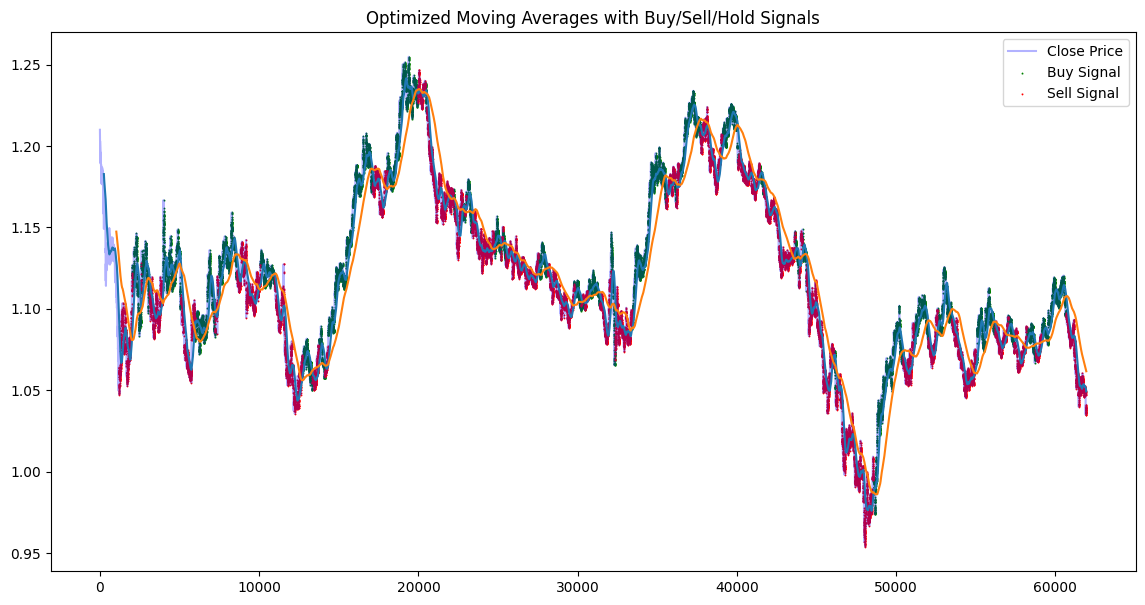

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"], label="Close Price", color="blue", alpha=0.3)
# plt.plot(data["Short_MA"], label=f"Short MA ({best_combination[0]} days)", color="green", alpha=0.3)
# plt.plot(data["Long_MA"], label=f"Long MA ({best_combination[1]} days)", color="red", alpha=0.3)

plt.plot(data["Close"].rolling(window=250).mean())
plt.plot(data["Close"].rolling(window=1030).mean())
# Add Buy/Sell signals
buy_signals = data[data["Signal"] == 1]
sell_signals = data[data["Signal"] == -1]

plt.scatter(buy_signals.index, buy_signals["Close"], label="Buy Signal", marker="^", color="green", alpha=1, s=0.2)
plt.scatter(sell_signals.index, sell_signals["Close"], label="Sell Signal", marker="v", color="red", alpha=1, s=0.2)

plt.title("Optimized Moving Averages with Buy/Sell/Hold Signals")
plt.legend()
plt.show()
